# <span style="color:darkgreen">DATSCIW261 ASSIGNMENT 13</span>
#### MIDS UC Berkeley, Machine Learning at Scale

<b>AUTHORS</b> : Rajesh Thallam <br>
<b>EMAIL</b>  : rajesh.thallam@ischool.berkeley.edu <br>
<b>WEEK</b>   : 13 <br>
<b>DATE</b>   : 09-Dec-15

***

<h2><span style="color:dodgerblue;font:12px">HW13.1</span></h2> 

<span style="color:firebrick; font-size: 120%;"><b>Spark implementation of basic PageRank</b></span>

<span style="color:CornflowerBlue">
Write a basic Spark implementation of the iterative PageRank algorithm that takes sparse adjacency lists as input. Make sure that your implementation utilizes teleportation (1-damping/the number of nodes in the network), and further, distributes the mass of dangling nodes with each iteration so that the output of each iteration is correctly normalized (sums to 1). <br><br>
[NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page, chooses the next page to which it will move by clicking at random, with probability d, one of the hyperlinks in the current page. This probability is represented by a so-called ‘damping factor’ d, where d ∈ (0, 1). Otherwise, with probability (1 − d), the surfer jumps to any web page in the network. If a page is a dangling end, meaning it has no outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform distribution and “teleports” to that page] <br><br>
In your Spark solution, please use broadcast variables and caching to make sure your code is as efficient as possible. <br><br>
As you build your code, use the following [test data to](s3://ucb-mids-mls-networks/PageRank-test.txt) check you implementation: <br><br>
Set the teleportation parameter  to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck your work with the true result, displayed in the first image in the Wikipedia articlehttps [PageRank](//en.wikipedia.org/wiki/PageRank) and here for reference are the corresponding resulting PageRank probabilities: <br><br>
A,0.033<br>
B,0.384<br>
C,0.343<br>
D,0.039<br>
E,0.081<br>
F,0.039<br>
G,0.016<br>
H,0.016<br>
I,0.016<br>
J,0.016<br>
K,0.016<br><br>
Run this experiment locally first. Report the local configuration that you used and how long in minutes and seconds it takes to complete your job. <br><br>
Repeat this experiment on AWS. Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete your job. (in your notebook, cat the cluster config file)
</span>

<span style="color:cornflowerblue; font-size: 120%;"><b>Algorithm</b></span>

```
Stage 1
Function Map(Pi, Value)
    #Value contains the url of a page and one of its outlinks:[Pi Pik]
1: output(Pi; Pik)
2: output(Pik; "")

Function Reduce(Text Key, Text Values[]
   #For Key = Pi, Values contains list of outlinks of P[Pi0 Pi1 Pi2 ...]
3: Outlinks <- Ranki(Initial Rank)
4: for each element Value in Values
5:   Outlinks += Value // add Value to Outlinks String
6: end for
7: output(Pi, Outlinks)
```

```
Function Stage-1-Map(Text Pi, Text Value)
    #Value contains the rank of page Pi and its outlinks: [Ri Pi0 Pi1 Pi2 ...]
1:  if page Pi has outlinks then
2:      for each outlink Pk in Value
3:          Ni = Number of outlinks
4:          output(Pk, (Ri + r + (1-a)/N)/Ni)
5:      end for
6:      output(Pi, "m" Pi0 Pi1 Pi2 ...)(m indicates that the value is the list of outlinks)
7:   else if page Pi doesn't have outlinks then
8:      output(-1, Ri + r + (1-a)/N)
9:      output(Pi, "m")
10:  end if

Function
   Stage-1-Reduce(Text Key, Text Values[])
     #For Key = -1, Values contains Rank contributions of pages without outlinks -> [Rn0 Rn1 Rn2 ...]
     #For Key = P, k, Values contains list of outlinks of Pk and rank contributions to Pk from other pages -> [[m Pi0 Pi1 Pi2 ...] R0/N0 R1/N1 R2/N2...]
11:
12:   if Key = -1 then
13:       r <- 0
14:       for each element Rni in Values
15:           r += Rni
16:       end for
17:       r = a * r/N  //N is the number of total pages
18:       Write r into a HDFS file
19:   else
20:       rk <- 0
21:       for each element Value in Values
22:           if Value is the list of outlinks then
23:               Outlinks <- Value delete m
24:           else
25:               rk += Ri/Ni
26:           end if
27:       end for
28:       rk = a * rk
29:       output(Pk, rk Outlinks)
30:   end if
```

In [87]:
import os
import sys #current as of 9/26/2015
spark_home = os.environ['SPARK_HOME'] = '/usr/local/spark'

if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.8.2.1-src.zip'))
execfile(os.path.join(spark_home,'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.5.2
      /_/

Using Python version 2.7.6 (default, Jun 22 2015 17:58:13)
SparkContext available as sc, HiveContext available as sqlContext.


<span style="color:cornflowerblue; font-size: 120%;"><b>Pagerank implemetation for toyset</b></span>

In [194]:
%%writefile pagerank_13_1.py
#!/usr/bin/python
import re
import sys
import os
import sys
import ast
from operator import add

from pyspark import SparkContext

def pagerank_init(line):
    # initialize page rank as 1/N for all nodes with 
    # outgoing links and emit with graph structure
    node, ol = line.split('\t')
    neighbors = '|'.join(ast.literal_eval(ol).keys())
    yield node.encode('utf-8'), [1/N, neighbors]

def distribute(node, rank_links):
    """Calculates URL contributions to the rank of other URLs."""
    r = rank_links[0]
    links = rank_links[1]

    ol = str(links).split('|')
    Ni = len(ol)

    # if the node is for dangling (i.e. no outgoing link),
    # emit the loss to redistribute to all the incoming
    # links to the dangling node
    if (Ni == 1 and ol[0] == '') or Ni == 0:
        yield 'DANGLING', r
    else:
        r_new = float(r)/float(Ni)
        for l in ol:
            yield l, r_new

    # recover graph structure
    if links <> '':
        yield node, links

# update pagerank by combining the mass
def combine_mass(rank_links):
    r = 0.0
    out = ''

    for i in rank_links.split('~'):
        try:
            i = ast.literal_eval(i)
            if type(i) == float:
                r += i
            else:
                out = i if i else out
        except:
            out = i if i else out
            pass

    return str(r) + '~' + str(out)

def update_pagerank(node, rank_links, loss, N, a = 0.15):
    r = 0.0
    out_links = ""    
        
    for i in str(rank_links).split('~'):
        try:
            i = ast.literal_eval(i)
            if type(i) == float:
                r = float(i)
            else:
                out_links = i if i else out_links
        except:
            out_links = i if i else out_links
            pass
    
    r_new = a * (1/N) + (1-a) * (loss/N + r)
    return node, [round(r_new, 5), out_links]
            
if __name__ == "__main__":
    if len(sys.argv) != 4:
        print("Usage: pagerank <source_file> <iterations> <target_file>")
        exit(-1)

    # Initialize the spark context.
    sc = SparkContext(appName="PythonPageRank")

    lines = sc.textFile(sys.argv[1], 1)
    N = 11.0
    D = 0.85
    a = 0.15

    # parse and initialize pagerank
    ranks = lines.flatMap(lambda pages: pagerank_init(pages))
    
    for iteration in range(int(sys.argv[2])):
        # contribution from each page
        contribs = ranks \
                    .flatMap(lambda (node, rank_links): distribute(node, rank_links)) \
                    .reduceByKey(lambda prev, curr: combine_mass(str(prev) + '~' + str(curr))).cache()
        
        # find dangling mass
        dangling_nodes = contribs.lookup('DANGLING')
        dangling_mass = 0.0 if len(dangling_nodes) == 0 else float(str(dangling_nodes[0]).strip('~'))

        # update page rank
        ranks_new = contribs \
                    .filter(lambda (k, v): k != 'DANGLING') \
                    .map(lambda (node, rank_links): update_pagerank(node, rank_links, dangling_mass, N, a))
        ranks = ranks_new
                
    ranks \
        .map(lambda (node, rank_links): (node, round(rank_links[0], 3), rank_links[1])) \
        .saveAsTextFile(sys.argv[3])
    
    sc.stop()

Overwriting pagerank_13_1.py


<span style="color:cornflowerblue; font-size: 120%;"><b>Running on Local</b></span>

In [185]:
#!/usr/bin/python
import time

start_time = time.time()

!rm -fR out_hw13_1
!time $SPARK_HOME/bin/spark-submit --name "PythonPageRank" --master local[4] ./pagerank_13_1.py ./PageRank-test.txt 100 out_hw13_1

end_time = time.time()

print "="*80
print "Time taken to find page rank of the network = {:.2f} seconds".format(end_time - start_time)
print "="*80

print "Pagerank of the graph is"
!cat out_hw13_1/part-000* | sort

15/12/07 15:17:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
15/12/07 15:17:14 WARN Utils: Your hostname, rtubuntu resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface eth0)
15/12/07 15:17:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
15/12/07 15:17:16 WARN MetricsSystem: Using default name DAGScheduler for source because spark.app.id is not set.
22.63user 1.86system 0:35.03elapsed 69%CPU (0avgtext+0avgdata 498340maxresident)k
0inputs+3104outputs (0major+269468minor)pagefaults 0swaps
Time taken to find page rank of the network = 35.26 seconds
Pagerank of the graph is
('A', 0.033, '')
('B', 0.384, 'C')
('C', 0.343, 'B')
('D', 0.039, 'A|B')
('E', 0.081, 'B|D|F')
('F', 0.039, 'B|E')
('G', 0.016, 'B|E')
('H', 0.016, 'B|E')
('I', 0.016, 'B|E')
('J', 0.016, 'E')
('K', 0.016, 'E')


<span style="color:cornflowerblue; font-size: 120%;"><b>Running on AWS</b></span>

In [ ]:
aws emr create-cluster --name "rt-hw13" --release-label emr-4.2.0 --applications Name=Spark --ec2-attributes KeyName=rthallam_sa_east --log-uri s3://ucb-mids-mls-rajeshthallam/hw13/logs --instance-type m3.xlarge  --instance-count 10 --use-default-roles --configurations file://./emr_config_spark_rt.json

In [186]:
!scp -i ~/rthallam_sa_east.pem ./PageRank-test_indexed.txt hadoop@ec2-54-233-144-86.sa-east-1.compute.amazonaws.com:/home/hadoop/src

PageRank-test_indexed.txt                     100%  168     0.2KB/s   00:00    


In [173]:
#!/usr/bin/python
import time

start_time = time.time()

# copying latest script
!scp -i ~/rthallam_sa_east.pem ./pagerank_13_1.py hadoop@ec2-54-233-144-86.sa-east-1.compute.amazonaws.com:/home/hadoop/src
# removing target directory
!aws s3 rm s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/ --recursive
# launching script
!ssh -i ~/rthallam_sa_east.pem hadoop@ec2-54-233-144-86.sa-east-1.compute.amazonaws.com /usr/lib/spark/bin/spark-submit --master yarn-cluster /home/hadoop/src/pagerank_13_1.py s3n://ucb-mids-mls-networks/PageRank-test.txt 100 s3n://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1
        
end_time = time.time()

print "="*80
print "Time taken to find page rank of the network = {:.2f} seconds".format(end_time - start_time)
print "="*80

print "Pagerank of the graph is"
!rm -f ./out_hw13_1/part*
!aws s3 cp s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/ ./out_hw13_1 --recursive
!cat out_hw13_1/part-000* | sort

pagerank_13_1.py                              100% 3062     3.0KB/s   00:00    
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/_SUCCESS
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/part-00009
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/part-00010
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/part-00000
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/part-00001
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/part-00005
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/part-00006
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/part-00004
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/part-00007
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/part-00011
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/part-00008
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/part-00012
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/part-00013

***

<h2><span style="color:dodgerblue;font:12px">HW13.2</span></h2> 

<span style="color:firebrick; font-size: 120%;"><b>Applying PageRank to the Wikipedia hyperlinks network</b></span>

<span style="color:CornflowerBlue">Run your Spark PageRank implementation on the Wikipedia dataset for 10 iterations, and display the top 100 ranked nodes (with alpha = 0.85). <br><br>
Run your PageRank implementation on the Wikipedia dataset for 50 iterations, and display the top 100 ranked nodes (with teleportation factor of 0.15). <br><br>
Plot the pagerank values for the top 100 pages resulting from the 50 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.  Comment on your findings.  Have the top 100 ranked pages changed? Have the pagerank values changed? Explain. <br><br>
Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete your job. <br><br>
NOTE: Wikipedia data is located on S3 at  <br>
-- s3://ucb-mids-mls-networks/wikipedia/ <br>
-- s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt # Graph <br>
-- s3://ucb-mids-mls-networks/wikipedia/indices.txt               # Page titles and page Ids
</span><br>

<span style="color:CornflowerBlue; font-size:120%">**Cluster Creation for Wiki Page Rank**</span><br>

In [ ]:
aws emr create-cluster --name "rt-hw13" \
    --release-label emr-4.2.0 \
    --applications Name=Spark \
    --ec2-attributes KeyName=rthallam_sa_east \
    --log-uri s3://ucb-mids-mls-rajeshthallam/hw13/logs \
    --instance-type m3.xlarge  \
    --instance-count 10 \
    --use-default-roles \
    --configurations file://./emr_config_spark_rt.json \
    --bootstrap-actions Path=s3://ucb-mids-mls-rajeshthallam/bootstrap_actions.sh

<span style="color:CornflowerBlue; font-size:120%">**Running with indexed toy data set**</span><br>

In [189]:
#!/usr/bin/python
import time

start_time = time.time()

# copying latest script
!scp -i ~/rthallam_sa_east.pem ./pagerank_13_1.py hadoop@ec2-54-233-144-86.sa-east-1.compute.amazonaws.com:/home/hadoop/src
# removing target directory
!aws s3 rm s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/ --recursive
# launching script
!ssh -i ~/rthallam_sa_east.pem hadoop@ec2-54-233-144-86.sa-east-1.compute.amazonaws.com /usr/lib/spark/bin/spark-submit --master yarn-cluster /home/hadoop/src/pagerank_13_1.py s3n://ucb-mids-mls-rajeshthallam/hw13/PageRank-test_indexed.txt 100 s3n://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1
        
end_time = time.time()

print "="*80
print "Time taken to find page rank of the network = {:.2f} seconds".format(end_time - start_time)
print "="*80

print "Pagerank of the graph is"
!rm -f ./out_hw13_1/part*
!aws s3 cp s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/ ./out_hw13_1 --recursive
!cat out_hw13_1/part-000* | sort

pagerank_13_1.py                              100% 3220     3.1KB/s   00:00    
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/_SUCCESS
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/part-00005
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/part-00010
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/part-00009
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/part-00011
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/part-00012
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/part-00013
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/part-00015
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/part-00014
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/part-00017
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/part-00016
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/part-00019
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_1/part-00020

<span style="color:CornflowerBlue; font-size:120%">**Pagerank on Wikipedia data set**</span><br>

In [7]:
%%writefile pagerank_13_2.py
#!/usr/bin/python
import re
import sys
import os
import sys
import ast
from operator import add

from pyspark import SparkContext

def pagerank_init(line):
    # initialize page rank as 1/N for all nodes with 
    # outgoing links and emit with graph structure
    node, ol = line.split('\t')
    neighbors = '|'.join(ast.literal_eval(ol).keys())
    yield node.encode('utf-8'), [1/N, neighbors]

def distribute(node, rank_links):
    """Calculates URL contributions to the rank of other URLs."""
    r = rank_links[0]
    links = rank_links[1]

    ol = str(links).split('|')
    Ni = len(ol)

    # if the node is for dangling (i.e. no outgoing link),
    # emit the loss to redistribute to all the incoming
    # links to the dangling node
    if (Ni == 1 and ol[0] == '') or Ni == 0:
        yield 'DANGLING', r
    else:
        r_new = float(r)/float(Ni)
        for l in ol:
            yield l, r_new

    # recover graph structure
    if links <> '':
        yield node, links

# update pagerank by combining the mass
def combine_mass(rank_links):
    r = 0.0
    out = ''

    for i in rank_links.split('~'):
        try:
            i = ast.literal_eval(i)
            if type(i) == float:
                r += i
            else:
                out = i if i else out
        except:
            out = i if i else out
            pass

    return str(r) + '~' + str(out)

def update_pagerank(node, rank_links, loss, N, a = 0.15):
    r = 0.0
    out_links = ""    
        
    for i in str(rank_links).split('~'):
        try:
            i = ast.literal_eval(i)
            if type(i) == float:
                r = float(i)
            else:
                out_links = i if i else out_links
        except:
            out_links = i if i else out_links
            pass
    
    r_new = a * (1/N) + (1-a) * (loss/N + r)
    return node, [r_new, out_links]
            
if __name__ == "__main__":
    if len(sys.argv) != 4:
        print("Usage: pagerank <source_file> <iterations> <target_file>")
        exit(-1)

    # Initialize the spark context.
    sc = SparkContext(appName="WikiPageRank")

    lines = sc.textFile(sys.argv[1], 1)
    N = 15192277.0
    #N = 11.0
    D = 0.85
    a = 0.15
    
    # parse and initialize pagerank
    ranks = lines.flatMap(lambda pages: pagerank_init(pages))
    
    for iteration in range(int(sys.argv[2])):
        # contribution from each page
        contribs = ranks \
                    .flatMap(lambda (node, rank_links): distribute(node, rank_links)) \
                    .reduceByKey(lambda prev, curr: combine_mass(str(prev) + '~' + str(curr))).cache()
        
        # find dangling mass
        dangling_nodes = contribs.lookup('DANGLING')
        dangling_mass = 0.0 if len(dangling_nodes) == 0 else float(str(dangling_nodes[0]).strip('~'))

        # update page rank
        ranks_new = contribs \
                    .filter(lambda (k, v): k != 'DANGLING') \
                    .map(lambda (node, rank_links): update_pagerank(node, rank_links, dangling_mass, N, a))
        ranks = ranks_new.cache()
        
        if iteration in [9, 49]:
            top_100 = ranks.top(100, key = lambda (node, rank_links): rank_links[0])
            sc.parallelize(top_100) \
                .map(lambda (node, rank_links): str(node) + '|' + str(rank_links[0])) \
                .saveAsTextFile(sys.argv[3] + "/" + str(iteration))
        
    sc.stop()

Overwriting pagerank_13_2.py


<span style="color:CornflowerBlue; font-size:120%">**Running Pagerank on Wikipedia data set for 10 iterations**</span><br>

In [ ]:
#!/usr/bin/python
import time

start_time = time.time()

# copying latest script
!scp -i ~/rthallam_sa_east.pem ./pagerank_13_2.py hadoop@ec2-54-233-144-86.sa-east-1.compute.amazonaws.com:/home/hadoop/src
# removing target directory
!aws s3 rm s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_2/iter_10/ --recursive
# launching script
!ssh -i ~/rthallam_sa_east.pem hadoop@ec2-54-233-144-86.sa-east-1.compute.amazonaws.com /usr/lib/spark/bin/spark-submit --master yarn-cluster /home/hadoop/src/pagerank_13_2.py s3n://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt 10 s3n://ucb-mids-mls-rajeshthallam/hw13/results/hw13_2/iter_10/ > ./hw_13_2_iter10.log 2>&1
#!ssh -i ~/rthallam_sa_east.pem hadoop@ec2-54-233-144-86.sa-east-1.compute.amazonaws.com /usr/lib/spark/bin/spark-submit --master yarn-cluster /home/hadoop/src/pagerank_13_2.py s3n://ucb-mids-mls-rajeshthallam/hw13/PageRank-test_indexed.txt 10 s3n://ucb-mids-mls-rajeshthallam/hw13/results/hw13_2/iter_10/
        
end_time = time.time()

print "="*80
print "Time taken to find page rank of the network = {:.2f} seconds".format(end_time - start_time)
print "="*80

```
pagerank_13_2.py                              100% 3463     3.4KB/s   00:00    
15/12/08 02:31:23 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
15/12/08 02:31:24 INFO client.RMProxy: Connecting to ResourceManager at ip-172-31-32-212.sa-east-1.compute.internal/172.31.32.212:8032
15/12/08 02:31:24 INFO yarn.Client: Requesting a new application from cluster with 9 NodeManagers
15/12/08 02:31:24 INFO yarn.Client: Verifying our application has not requested more than the maximum memory capability of the cluster (11520 MB per container)
15/12/08 02:31:24 INFO yarn.Client: Will allocate AM container, with 1408 MB memory including 384 MB overhead
15/12/08 02:31:24 INFO yarn.Client: Setting up container launch context for our AM
15/12/08 02:31:24 INFO yarn.Client: Setting up the launch environment for our AM container
15/12/08 02:31:24 INFO yarn.Client: Preparing resources for our AM container
15/12/08 02:31:24 INFO yarn.Client: Uploading resource file:/usr/lib/spark/lib/spark-assembly-1.5.2-hadoop2.6.0-amzn-2.jar -> hdfs://ip-172-31-32-212.sa-east-1.compute.internal:8020/user/hadoop/.sparkStaging/application_1449482525945_0035/spark-assembly-1.5.2-hadoop2.6.0-amzn-2.jar
15/12/08 02:31:25 INFO metrics.MetricsSaver: MetricsConfigRecord disabledInCluster: false instanceEngineCycleSec: 60 clusterEngineCycleSec: 60 disableClusterEngine: false maxMemoryMb: 3072 maxInstanceCount: 500 lastModified: 1449482533009 
15/12/08 02:31:25 INFO metrics.MetricsSaver: Created MetricsSaver j-KBN00RIHUZBE:i-d5952e37:SparkSubmit:03344 period:60 /mnt/var/em/raw/i-d5952e37_20151208_SparkSubmit_03344_raw.bin
15/12/08 02:31:26 INFO metrics.MetricsSaver: 1 aggregated HDFSWriteDelay 1152 raw values into 1 aggregated values, total 1
15/12/08 02:31:26 INFO yarn.Client: Uploading resource file:/home/hadoop/src/pagerank_13_2.py -> hdfs://ip-172-31-32-212.sa-east-1.compute.internal:8020/user/hadoop/.sparkStaging/application_1449482525945_0035/pagerank_13_2.py
15/12/08 02:31:26 INFO yarn.Client: Uploading resource file:/usr/lib/spark/python/lib/pyspark.zip -> hdfs://ip-172-31-32-212.sa-east-1.compute.internal:8020/user/hadoop/.sparkStaging/application_1449482525945_0035/pyspark.zip
15/12/08 02:31:26 INFO yarn.Client: Uploading resource file:/usr/lib/spark/python/lib/py4j-0.8.2.1-src.zip -> hdfs://ip-172-31-32-212.sa-east-1.compute.internal:8020/user/hadoop/.sparkStaging/application_1449482525945_0035/py4j-0.8.2.1-src.zip
15/12/08 02:31:26 INFO yarn.Client: Uploading resource file:/tmp/spark-3c2f91b6-6d4b-480d-a130-bd8c5bc68322/__spark_conf__8771859733817262757.zip -> hdfs://ip-172-31-32-212.sa-east-1.compute.internal:8020/user/hadoop/.sparkStaging/application_1449482525945_0035/__spark_conf__8771859733817262757.zip
15/12/08 02:31:26 INFO spark.SecurityManager: Changing view acls to: hadoop
15/12/08 02:31:26 INFO spark.SecurityManager: Changing modify acls to: hadoop
15/12/08 02:31:26 INFO spark.SecurityManager: SecurityManager: authentication disabled; ui acls disabled; users with view permissions: Set(hadoop); users with modify permissions: Set(hadoop)
15/12/08 02:31:26 INFO yarn.Client: Submitting application 35 to ResourceManager
15/12/08 02:31:26 INFO impl.YarnClientImpl: Submitted application application_1449482525945_0035
15/12/08 02:31:27 INFO yarn.Client: Application report for application_1449482525945_0035 (state: ACCEPTED)
...
15/12/08 04:25:32 INFO yarn.Client: Application report for application_1449482525945_0035 (state: RUNNING)
15/12/08 04:25:33 INFO yarn.Client: Application report for application_1449482525945_0035 (state: FINISHED)
15/12/08 04:25:33 INFO yarn.Client: 
	 client token: N/A
	 diagnostics: N/A
	 ApplicationMaster host: 172.31.42.131
	 ApplicationMaster RPC port: 0
	 queue: default
	 start time: 1449541886956
	 final status: SUCCEEDED
	 tracking URL: http://ip-172-31-32-212.sa-east-1.compute.internal:20888/proxy/application_1449482525945_0035/history/application_1449482525945_0035/1
	 user: hadoop
15/12/08 04:25:33 INFO util.ShutdownHookManager: Shutdown hook called
15/12/08 04:25:33 INFO util.ShutdownHookManager: Deleting directory /tmp/spark-3c2f91b6-6d4b-480d-a130-bd8c5bc68322
================================================================================
Time taken to find page rank of the network = 6866.21 seconds
================================================================================
```

In [7]:
!rm -f ./out_hw13_2/iter_10/part*
!aws s3 cp s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_2/iter_10/9/ ./out_hw13_2/iter_10/ --recursive
!cat ./out_hw13_2/iter_10/part* > ./out_hw13_2/top100_pr_10iter.txt
!head ./out_hw13_2/top100_pr_10iter.txt

download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_2/iter_10/9/_SUCCESS to out_hw13_2/iter_10/_SUCCESS
download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_2/iter_10/9/part-00002 to out_hw13_2/iter_10/part-00002
download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_2/iter_10/9/part-00000 to out_hw13_2/iter_10/part-00000
download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_2/iter_10/9/part-00004 to out_hw13_2/iter_10/part-00004
download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_2/iter_10/9/part-00009 to out_hw13_2/iter_10/part-00009
download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_2/iter_10/9/part-00003 to out_hw13_2/iter_10/part-00003
download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_2/iter_10/9/part-00005 to out_hw13_2/iter_10/part-00005
download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_2/iter_10/9/part-00006 to out_hw13_2/iter_10/part-00006
download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_2/iter_10/9/part

<span style="color:CornflowerBlue; font-size:120%">**Running Pagerank on Wikipedia data set for 50 iterations**</span><br>

In [ ]:
#!/usr/bin/python
import time

start_time = time.time()

# copying latest script
!scp -i ~/rthallam_sa_east.pem ./pagerank_13_2.py hadoop@ec2-54-233-144-86.sa-east-1.compute.amazonaws.com:/home/hadoop/src
# removing target directory
!aws s3 rm s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_2/iter_10/ --recursive
# launching script
!ssh -i ~/rthallam_sa_east.pem hadoop@ec2-54-233-144-86.sa-east-1.compute.amazonaws.com /usr/lib/spark/bin/spark-submit --master yarn-cluster /home/hadoop/src/pagerank_13_2.py s3n://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt 50 s3n://ucb-mids-mls-rajeshthallam/hw13/results/hw13_2/iter_10/ > ./hw_13_2_iter10.log 2>&1
        
end_time = time.time()

print "="*80
print "Time taken to find page rank of the network = {:.2f} seconds".format(end_time - start_time)
print "="*80

<table> 
<caption><b>Cluster Configuration and Run Time</b></caption>
<tr><td><b>Cluster Size</b></td><td>9 mx.large (WORKERS) and 1 mx.large (MASTER)</td></tr>
<tr><td><b>Run time</b></td><td>10hours 10 minutes</td></tr>
</table>

![Pagerank with 50 iterations](./hw13_2_w_50_iter.png)

In [8]:
!rm -f ./out_hw13_2/iter_50/part*
!aws s3 cp s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_2/iter_10/49/ ./out_hw13_2/iter_50/ --recursive
!cat ./out_hw13_2/iter_50/part* > ./out_hw13_2/top100_pr_50iter.txt
!head ./out_hw13_2/top100_pr_50iter.txt

download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_2/iter_10/49/part-00001 to out_hw13_2/iter_50/part-00001
download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_2/iter_10/49/part-00000 to out_hw13_2/iter_50/part-00000
download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_2/iter_10/49/_SUCCESS to out_hw13_2/iter_50/_SUCCESS
download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_2/iter_10/49/part-00002 to out_hw13_2/iter_50/part-00002
download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_2/iter_10/49/part-00004 to out_hw13_2/iter_50/part-00004
download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_2/iter_10/49/part-00006 to out_hw13_2/iter_50/part-00006
download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_2/iter_10/49/part-00003 to out_hw13_2/iter_50/part-00003
download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_2/iter_10/49/part-00005 to out_hw13_2/iter_50/part-00005
download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_2/iter_1

<span style="color:CornflowerBlue; font-size:120%">**Results**</span><br>

In [2]:
#!/usr/bin/python
from tabulate import tabulate
import sys
import os

LOOKUP = os.path.join('out_hw13_2', 'indices.txt')
TOP10_ITER = os.path.join('out_hw13_2', 'top100_pr_10iter.txt')
TOP50_ITER = os.path.join('out_hw13_2', 'top100_pr_50iter.txt')

lookup = { key.strip():value.strip() for value, key, v1, v2 in (line.split("\t") for line in open(LOOKUP).read().strip().split('\n')) }
pr_10 = [ (page, float(rank)) for page, rank in (line.split("|") for line in open(TOP10_ITER).read().strip().split('\n')) ]
pr_50 = [ (page, float(rank)) for page, rank in (line.split("|") for line in open(TOP50_ITER).read().strip().split('\n')) ]

pr_10 = sorted(pr_10, key=lambda x: -x[1])
pr_50 = sorted(pr_50, key=lambda x: -x[1])

In [5]:
print "-"*100
print "Comparing Top 100 pages with {} and {} iterations".format(10, 50)
print "-"*100

results = []
for i in xrange(100):
    results.append([
                    i+1, 
                    lookup.get(pr_10[i][0].replace("\"",""), 'NA'),
                    pr_10[i][1], 
                    lookup.get(pr_50[i][0].replace("\"",""), 'NA'),
                    pr_50[i][1]
                    ])

print tabulate(results, headers=["#","Page (10)", "Rank (10)", "Page (50)", "Rank (50)"])

----------------------------------------------------------------------------------------------------
Comparing Top 100 pages with 10 and 50 iterations
----------------------------------------------------------------------------------------------------
  #  Page (10)                                   Rank (10)  Page (50)                                   Rank (50)
---  ----------------------------------------  -----------  ----------------------------------------  -----------
  1  United States                             0.00124386   United States                             0.00146123
  2  Animal                                    0.000586194  Animal                                    0.000665898
  3  France                                    0.000547762  France                                    0.000639539
  4  Germany                                   0.000491623  Germany                                   0.000574642
  5  Arthropod                                 0.00039802   Arthr

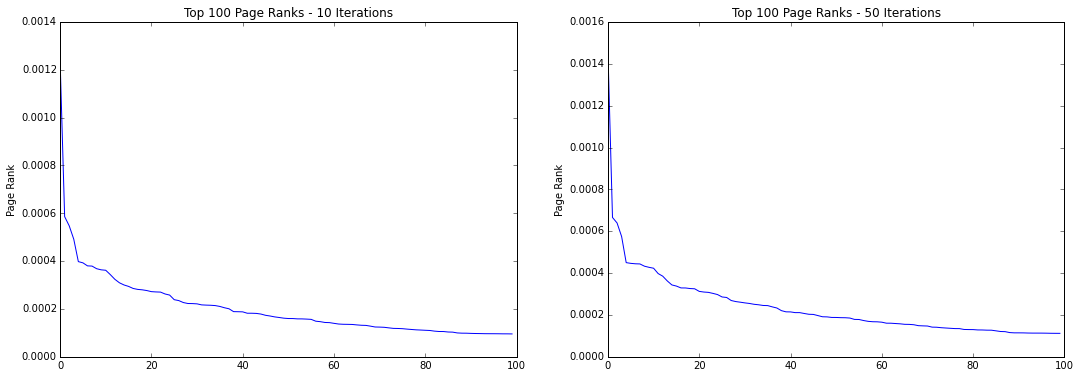

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure(figsize=(18,6))
plt.subplot(121)
plt.title("Top 100 Page Ranks - 10 Iterations")
plt.ylabel('Page Rank')
plt.plot([pr[1] for pr in pr_10])

plt.subplot(122)
plt.title("Top 100 Page Ranks - 50 Iterations")
plt.ylabel('Page Rank')
plt.plot([pr[1] for pr in pr_50])

<span style="color:CornflowerBlue; font-size:120%">**Report**</span><br>

- Pages associated with top 100 ranks for both 10 and 50 iterations are almost same though their order is different
- Page rank values itself differ between 10 and 50 iterations and with 50 iterations these tend to be relatively higher

***

<h2><span style="color:dodgerblue;font:12px">HW13.3</span></h2> 

<span style="color:firebrick; font-size: 120%;"><b>Spark GraphX versus your implementation of PageRank</b></span>

<span style="color:CornflowerBlue ">Run the Spark  GraphX PageRank implementation on the Wikipedia dataset for 10 iterations, and display the top 100 ranked nodes (with alpha = 0.85). <br><br>
Run your PageRank implementation on the Wikipedia dataset for 50 iterations, and display the top 100 ranked nodes (with teleportation factor of 0.15). Have the top 100 ranked pages changed? Comment on your findings. Plot both 100 curves.<br><br>
Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete this job.<br><br>
Put the runtime results of HW13.2 and HW13.3 in a tabular format (with rows corresponding to implemention and columns corresponding to experiment setup (10 iterations, 50 iterations)). Discuss the run times and explaing the differences. <br><br>
Plot the pagerank values for the top 100 pages resulting from the 50 iterations run (using GraphX). Then plot the pagerank values for the same 100 pages that resulted from the 50 iterations run of your homegrown pagerank implemnentation.  Comment on your findings.  Have the top 100 ranked pages changed? Have the pagerank values changed? Explain.
</span><br>

<span style="color:firebrick; font-size: 120%;"><b>TO DO</b></span>

In [ ]:
import org.apache.spark.SparkContext
import org.apache.spark.SparkContext._
import org.apache.spark.SparkConf
import org.apache.spark.graphx._
import org.apache.spark.rdd.RDD

object Pagerank {
        def main(args: Array[String]) {
        val conf = new SparkConf().setAppName("pagerank")
        val sc = new SparkContext(conf)
        val graph = GraphLoader.edgeListFile(sc, "file:/home/hadoop/src/pagerank/followers")
        // Run PageRank
        //val ranks = graph.pageRank(10).vertices
        val ranks = graph.pageRank(0.0001).vertices

        // Print the result
        println(ranks.collect().mkString("\n"))
    }
}

In [ ]:
name := "pagerank"
version := "1.0"
scalaVersion := "2.10.5"
libraryDependencies ++= Seq("org.apache.spark" %% "spark-core" % "1.5.2", "org.apache.spark" %% "spark-graphx" % "1.5.2")
resolvers += "Akka Repository" at "http://repo.akka.io/releases/"

In [ ]:
sbt package

In [ ]:
/usr/lib/spark/bin/spark-submit --class "Pagerank" --master local [4] $(find target -iname "*.jar")

***

<h2><span style="color:dodgerblue;font:12px">HW13.4</span></h2>

<span style="color:firebrick; font-size: 120%;"><b>Criteo Phase 2 baseline</b></span>

<span style="color:CornflowerBlue">The  Criteo data is located in the following S3 bucket: [criteo-dataset](https://console.aws.amazon.com/s3/home?region=us-west-1#&bucket=criteo-dataset&prefix=) <br><br>
Using the training dataset, validation dataset and testing dataset in the Criteo bucket perform the following experiment: <br><br>
-- write spark code (borrow from Phase 1 of this project) to train a logistic regression model with the following hyperparamters:<br>
-- Number of buckets for hashing: 1,000<br>
-- Logistic Regression: no regularization term<br>
-- Logistic Regression: step size = 10<br><br>
Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete this job.<br><br>
Report in tabular form the [AUC value](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) for the Training, Validation, and Testing datasets. Report in tabular form  the logLossTest for the Training, Validation, and Testing datasets. <br><br>
Dont forget to put a caption on your tables (above each table).</span><br>

<span style="color:cornflowerblue; font-size:120%"><b>Baseline Criteo Dataset using Raw Data</b></span>

In [1]:
%%writefile criteo_13_4_1.py
from collections import defaultdict
import hashlib
import sys
from math import log, exp
from pyspark import SparkContext
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.evaluation import BinaryClassificationMetrics

def hashFunction(numBuckets, rawFeats, printMapping=False):
    """Calculate a feature dictionary for an observation's features based on hashing.

    Note:
        Use printMapping=True for debug purposes and to better understand how the hashing works.

    Args:
        numBuckets (int): Number of buckets to use as features.
        rawFeats (list of (int, str)): A list of features for an observation.  Represented as
            (featureID, value) tuples.
        printMapping (bool, optional): If true, the mappings of featureString to index will be
            printed.

    Returns:
        dict of int to float:  The keys will be integers which represent the buckets that the
            features have been hashed to.  The value for a given key will contain the count of the
            (featureID, value) tuples that have hashed to that key.
    """
    mapping = {}
    for ind, category in rawFeats:
        featureString = category + str(ind)
        mapping[featureString] = int(int(hashlib.md5(featureString).hexdigest(), 16) % numBuckets)
    if(printMapping): print mapping
    sparseFeatures = defaultdict(float)
    for bucket in mapping.values():
        sparseFeatures[bucket] += 1.0
    return dict(sparseFeatures)

def parseHashPoint(point, numBuckets):
    """Create a LabeledPoint for this observation using hashing.

    Args:
        point (str): A comma separated string where the first value is the label and the rest are
            features.
        numBuckets: The number of buckets to hash to.

    Returns:
        LabeledPoint: A LabeledPoint with a label (0.0 or 1.0) and a SparseVector of hashed
            features.
    """
    parsedPoints = parsePoint(point)
    items = point.split(',')
    label = items[0]
    features = hashFunction(numBuckets, parsedPoints, printMapping=False)
    return LabeledPoint(label, SparseVector(numBuckets, features))

def parsePoint(point):
    """Converts a comma separated string into a list of (featureID, value) tuples.

    Note:
        featureIDs should start at 0 and increase to the number of features - 1.

    Args:
        point (str): A comma separated string where the first value is the label and the rest
            are features.

    Returns:
        list: A list of (featureID, value) tuples.
    """
    return [(i, item) for i, item in enumerate(point.split(',')[1:])]
    
def computeLogLoss(p, y):
    """Calculates the value of log loss for a given probabilty and label.

    Note:
        log(0) is undefined, so when p is 0 we need to add a small value (epsilon) to it
        and when p is 1 we need to subtract a small value (epsilon) from it.

    Args:
        p (float): A probabilty between 0 and 1.
        y (int): A label.  Takes on the values 0 and 1.

    Returns:
        float: The log loss value.
    """
    epsilon = 10e-12
    if p == 0:
        p = p + epsilon
    if p == 1:
        p = p - epsilon
    return -(y * log(p) + (1-y) * log(1-p))

def getP(x, w, intercept):
    """Calculate the probability for an observation given a set of weights and intercept.

    Note:
        We'll bound our raw prediction between 20 and -20 for numerical purposes.

    Args:
        x (SparseVector): A vector with values of 1.0 for features that exist in this
            observation and 0.0 otherwise.
        w (DenseVector): A vector of weights (betas) for the model.
        intercept (float): The model's intercept.

    Returns:
        float: A probability between 0 and 1.
    """
    rawPrediction = x.dot(w) + intercept

    # Bound the raw prediction value
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)
    return 1 / (1 + exp(-rawPrediction))

def evaluateResults(model, data):
    """Calculates the log loss for the data given the model.

    Args:
        model (LogisticRegressionModel): A trained logistic regression model.
        data (RDD of LabeledPoint): Labels and features for each observation.

    Returns:
        float: Log loss for the data.
    """
    return data.map(lambda x: computeLogLoss(getP(x.features, model.weights, model.intercept), x.label)).sum() / data.count()

def evaluateMetrics(model, data, label):
    labelsAndScores = data.map(lambda lp:
                            (lp.label, getP(lp.features, model.weights, model.intercept)))
    
    auc = BinaryClassificationMetrics(labelsAndScores).areaUnderROC
    log_loss = evaluateResults(model, data)

    sys.stderr.write('\n LogLoss {0} = {1}'.format(label, log_loss))
    sys.stderr.write('\n AUC {0} = {1}\n'.format(label, auc))
    
    return (label, log_loss, auc)

if __name__ == '__main__':  
    # Initialize the spark context.
    sc = SparkContext(appName="CriteoBaseline")

    # =========================
    # read raw criteo data set
    # =========================
    rawTrainData = (sc
               .textFile(sys.argv[1], 2)
               .map(lambda x: x.replace('\t', ','))
               .cache() )# work with either ',' or '\t' separated data
    print rawTrainData.take(1)
    
    rawTestData = (sc
               .textFile(sys.argv[2], 2)
               .map(lambda x: x.replace('\t', ','))
               .cache() )# work with either ',' or '\t' separated data
    print rawTestData.take(1)
    
    rawValidationData = (sc
               .textFile(sys.argv[3], 2)
               .map(lambda x: x.replace('\t', ','))
               .cache() )# work with either ',' or '\t' separated data
    print rawValidationData.take(1)

    # ===================================================
    # split into train, validation and test data set
    # ===================================================
    #weights = [.8, .1, .1]
    #seed = 42
    # Use randomSplit with weights and seed
    #rawTrainData, rawValidationData, rawTestData = rawData.randomSplit(weights, seed)
    # Cache the data
    #rawTrainData.cache()
    #rawValidationData.cache()
    #rawTestData.cache()

    nTrain = rawTrainData.count()
    nVal = rawValidationData.count()
    nTest = rawTestData.count()
    print nTrain, nVal, nTest, nTrain + nVal + nTest

    # ===================================================
    # create hash features
    # ===================================================
    numBucketsCTR = 1000    # number of hash buckets

    hashTrainData = rawTrainData.map(lambda x: parseHashPoint(x, numBucketsCTR))
    hashTrainData.cache()
    hashValidationData = rawValidationData.map(lambda x: parseHashPoint(x, numBucketsCTR))
    hashValidationData.cache()
    hashTestData = rawTestData.map(lambda x: parseHashPoint(x, numBucketsCTR))
    hashTestData.cache()

    # ===================================================
    # train logistic regression model
    # ===================================================    
    numIters = 100
    stepSize = 10.
    regParam = 0. # no regularization
    regType = 'l2'
    includeIntercept = True

    model = LogisticRegressionWithSGD.train(hashTrainData, 
                                            iterations=numIters, 
                                            step=stepSize, 
                                            regParam=regParam, 
                                            regType=regType, 
                                            intercept=includeIntercept) 
    sortedWeights = sorted(model.weights)

    sys.stderr.write('\n Model Intercept: {0}'.format(model.intercept))
    sys.stderr.write('\n Model Weights (Top 5): {0}\n'.format(sortedWeights[:5]))
    
    l_metrics = []
    
    l_metrics.append(evaluateMetrics(model, hashTrainData, 'TRAIN'))
    l_metrics.append(evaluateMetrics(model, hashValidationData, 'VALIDATE'))
    l_metrics.append(evaluateMetrics(model, hashTestData, 'TEST'))
    
    sc.parallelize(l_metrics).saveAsTextFile(sys.argv[4])
    
    sc.stop()

Overwriting criteo_13_4_1.py


In [ ]:
#!/usr/bin/python
import time

start_time = time.time()

# copying latest script
!scp -i ~/rthallam_sa_east.pem ./criteo_13_4_1.py hadoop@ec2-54-233-134-187.sa-east-1.compute.amazonaws.com:/home/hadoop/src
# removing target directory
!aws s3 rm s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_4/ --recursive
# launching script
!ssh -i ~/rthallam_sa_east.pem hadoop@ec2-54-233-134-187.sa-east-1.compute.amazonaws.com \
    /usr/lib/spark/bin/spark-submit --master yarn-cluster \
    /home/hadoop/src/criteo_13_4_1.py \
    s3://criteo-dataset/rawdata/train/ \
    s3://criteo-dataset/rawdata/test/ \
    s3://criteo-dataset/rawdata/validation/ \
    s3n://ucb-mids-mls-rajeshthallam/hw13/results/hw13_4/
#!ssh -i ~/rthallam_sa_east.pem hadoop@ec2-54-233-144-86.sa-east-1.compute.amazonaws.com /usr/lib/spark/bin/spark-submit --master yarn-cluster /home/hadoop/src/pagerank_13_2.py s3n://ucb-mids-mls-rajeshthallam/hw13/PageRank-test_indexed.txt 10 s3n://ucb-mids-mls-rajeshthallam/hw13/results/hw13_2/iter_10/
        
end_time = time.time()

print "="*80
print "Time taken to find baseline metrics of the Criteo data set = {:.2f} seconds".format(end_time - start_time)
print "="*80

In [2]:
#Download results
!rm -fR .out_hw13_4/part*
!aws s3 cp s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_4/ . --recursive
    
print "Results (raw)"
!cat part*

download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_4/part-00000 to ./part-00000
download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_4/part-00005 to ./part-00005
download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_4/part-00004 to ./part-00004
download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_4/part-00001 to ./part-00001
download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_4/part-00008 to ./part-00008
download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_4/part-00003 to ./part-00003
download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_4/part-00002 to ./part-00002
download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_4/_SUCCESS to ./_SUCCESS
download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_4/part-00006 to ./part-00006
download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_4/part-00007 to ./part-00007
download: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_4/part-00011 to ./part-00011
download: s3://ucb-mids-m

<span style="color:cornflowerblue; font-size:120%"><b>Results</b></span>

<span style="color:cornflowerblue; font-size:120%"><b>Results</b></span>

<table> 
<caption>Cluster Configuration and Run Time</caption>
<tr><td><b>Cluster Size</b></td><td>3 mx.large (WORKERS) and 1 mx.large (MASTER)</td></tr>
<tr><td><b>Run time</b></td><td>2hours 46 minutes</td></tr>
</table>

![hw_13_4_runtime](hw_13_4_EMR.png)

<table> 
<caption><b>Model parameters</b></caption>
<tr>
    <th>Parameter</th>
    <th>Value</th>
</tr>
<tr><td>Iterations</td><td>100</td></tr>
<tr><td>Regularization</td><td>0.0</td></tr>
<tr><td>Regularization Type</td><td>L2</td></tr>
<tr><td>Include Intercept</td><td>True</td></tr>
<tr><td>Step Size</td><td>10</td></tr>
</table>

<table> 
<caption><b>Results: Log loss and AUC</b></caption>
<tr>
    <th>Data set</th>
    <th>Log Loss</th>
    <th>AUC</th>
</tr>
<tr><td>TRAIN</td><td>0.5054639969509631</td><td>0.6914759771327955</td></tr>
<tr><td>VALIDATION</td><td>0.5056761120760903</td><td>0.6918797233560421</td></tr>
<tr><td>TEST</td><td>0.505602800351624</td><td>0.6920070004287929</td></tr>
</table>

***

<h2><span style="color:dodgerblue;font:12px">HW13.5</span></h2> 

<span style="color:firebrick; font-size: 120%;"><b>Criteo Phase 2 Hyperparameter Tuning</b></span>

<span style="color:CornflowerBlue ">Using the training dataset, validation dataset and testing dataset in the Criteo bucket perform the following experiments: <br><br>
-- write spark code (borrow from Phase 1 of this project) to train a logistic regression model with various hyperparamters. Do a gridsearch of the hyperparameter space and determine optimal settings using the validation set.<br>
-- Number of buckets for hashing: 1,000, 10,000, .... explore different values  here<br>
-- Logistic Regression: regularization term: [1e-6, 1e-3]  explore other  values here also<br>
-- Logistic Regression: step size: explore different step sizes. Focus on a stepsize of 1 initially.<br><br>
Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete this job.<br><br>
Report in tabular form and using heatmaps the [AUC values](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) for the Training, Validation, and Testing datasets. Report in tabular form and using heatmaps  the logLossTest for the Training, Validation, and Testing datasets.<br><br>
Dont forget to put a caption on your tables (above the table) and on your heatmap figures (put caption below figures) detailing the experiment associated with each table or figure (data, algorithm used, parameters and settings explored.<br><br>
Discuss the optimal setting to solve this problem in terms of the following:<br>
-- Features<br>
-- Learning algortihm<br>
-- Spark cluster<br><br>
Justiy your recommendations based on your experimental results and cross reference with table numbers and figure numbers. Also highlight key results with annotations, both textual and line and box based, on your tables and graphs.
</span><br>

<span style="color:cornflowerblue; font-size: 120%;"><b>Criteo Phase 2 Hyperparameter Tuning</b></span>

In [1]:
%%writefile criteo_13_5_1.py
from collections import defaultdict
import hashlib
import sys
from math import log, exp
from pyspark import SparkContext
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.evaluation import BinaryClassificationMetrics

def hashFunction(numBuckets, rawFeats, printMapping=False):
    """Calculate a feature dictionary for an observation's features based on hashing.

    Note:
        Use printMapping=True for debug purposes and to better understand how the hashing works.

    Args:
        numBuckets (int): Number of buckets to use as features.
        rawFeats (list of (int, str)): A list of features for an observation.  Represented as
            (featureID, value) tuples.
        printMapping (bool, optional): If true, the mappings of featureString to index will be
            printed.

    Returns:
        dict of int to float:  The keys will be integers which represent the buckets that the
            features have been hashed to.  The value for a given key will contain the count of the
            (featureID, value) tuples that have hashed to that key.
    """
    mapping = {}
    for ind, category in rawFeats:
        featureString = category + str(ind)
        mapping[featureString] = int(int(hashlib.md5(featureString).hexdigest(), 16) % numBuckets)
    if(printMapping): print mapping
    sparseFeatures = defaultdict(float)
    for bucket in mapping.values():
        sparseFeatures[bucket] += 1.0
    return dict(sparseFeatures)

def parseHashPoint(point, numBuckets):
    """Create a LabeledPoint for this observation using hashing.

    Args:
        point (str): A comma separated string where the first value is the label and the rest are
            features.
        numBuckets: The number of buckets to hash to.

    Returns:
        LabeledPoint: A LabeledPoint with a label (0.0 or 1.0) and a SparseVector of hashed
            features.
    """
    parsedPoints = parsePoint(point)
    items = point.split(',')
    label = items[0]
    features = hashFunction(numBuckets, parsedPoints, printMapping=False)
    return LabeledPoint(label, SparseVector(numBuckets, features))

def parsePoint(point):
    """Converts a comma separated string into a list of (featureID, value) tuples.

    Note:
        featureIDs should start at 0 and increase to the number of features - 1.

    Args:
        point (str): A comma separated string where the first value is the label and the rest
            are features.

    Returns:
        list: A list of (featureID, value) tuples.
    """
    return [(i, item) for i, item in enumerate(point.split(',')[1:])]
    
def computeLogLoss(p, y):
    """Calculates the value of log loss for a given probabilty and label.

    Note:
        log(0) is undefined, so when p is 0 we need to add a small value (epsilon) to it
        and when p is 1 we need to subtract a small value (epsilon) from it.

    Args:
        p (float): A probabilty between 0 and 1.
        y (int): A label.  Takes on the values 0 and 1.

    Returns:
        float: The log loss value.
    """
    epsilon = 10e-12
    if p == 0:
        p = p + epsilon
    if p == 1:
        p = p - epsilon
    return -(y * log(p) + (1-y) * log(1-p))

def getP(x, w, intercept):
    """Calculate the probability for an observation given a set of weights and intercept.

    Note:
        We'll bound our raw prediction between 20 and -20 for numerical purposes.

    Args:
        x (SparseVector): A vector with values of 1.0 for features that exist in this
            observation and 0.0 otherwise.
        w (DenseVector): A vector of weights (betas) for the model.
        intercept (float): The model's intercept.

    Returns:
        float: A probability between 0 and 1.
    """
    rawPrediction = x.dot(w) + intercept

    # Bound the raw prediction value
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)
    return 1 / (1 + exp(-rawPrediction))

def evaluateResults(model, data):
    """Calculates the log loss for the data given the model.

    Args:
        model (LogisticRegressionModel): A trained logistic regression model.
        data (RDD of LabeledPoint): Labels and features for each observation.

    Returns:
        float: Log loss for the data.
    """
    return data.map(lambda x: computeLogLoss(getP(x.features, model.weights, model.intercept), x.label)).sum() / data.count()

def evaluateMetrics(model, data, label):
    labelsAndScores = data.map(lambda lp:
                            (lp.label, getP(lp.features, model.weights, model.intercept)))
    
    auc = BinaryClassificationMetrics(labelsAndScores).areaUnderROC
    log_loss = evaluateResults(model, data)

    sys.stderr.write('\n LogLoss {0} = {1}'.format(label, log_loss))
    sys.stderr.write('\n AUC {0} = {1}\n'.format(label, auc))
    
    return (label, log_loss, auc)

if __name__ == '__main__':  
    # Initialize the spark context.
    sc = SparkContext(appName="CriteoBaseline")

    # =========================
    # read raw criteo data set
    # =========================
    rawTrainData = (sc
               .textFile(sys.argv[1], 2)
               .map(lambda x: x.replace('\t', ','))
               .cache() )# work with either ',' or '\t' separated data
    print rawTrainData.take(1)
    
    rawTestData = (sc
               .textFile(sys.argv[2], 2)
               .map(lambda x: x.replace('\t', ','))
               .cache() )# work with either ',' or '\t' separated data
    print rawTestData.take(1)
    
    rawValidationData = (sc
               .textFile(sys.argv[3], 2)
               .map(lambda x: x.replace('\t', ','))
               .cache() )# work with either ',' or '\t' separated data
    print rawValidationData.take(1)

    # ===================================================
    # split into train, validation and test data set
    # ===================================================
    #weights = [.8, .1, .1]
    #seed = 42
    # Use randomSplit with weights and seed
    #rawTrainData, rawValidationData, rawTestData = rawData.randomSplit(weights, seed)
    # Cache the data
    #rawTrainData.cache()
    #rawValidationData.cache()
    #rawTestData.cache()

    nTrain = rawTrainData.count()
    nVal = rawValidationData.count()
    nTest = rawTestData.count()
    print nTrain, nVal, nTest, nTrain + nVal + nTest

    # ===================================================
    # create hash features
    # ===================================================
    numBucketsCTR = [1000, 10000, 10000]    # number of hash buckets
    iteration = 0
    
    for numBuckets in numBucketsCTR:
        hashTrainData = rawTrainData.map(lambda x: parseHashPoint(x, numBuckets))
        hashTrainData.cache()
        hashValidationData = rawValidationData.map(lambda x: parseHashPoint(x, numBuckets))
        hashValidationData.cache()
        hashTestData = rawTestData.map(lambda x: parseHashPoint(x, numBuckets))
        hashTestData.cache()

        # ===================================================
        # train logistic regression model
        # ===================================================    
        numIters = 10
        stepSizes = [1, 10, 100]
        regParams = [1e-6, 1e-3, 1e-1, 0]
        regType = 'l2'
        includeIntercept = True

        for stepSize in stepSizes:
            for regParam in regParams:
                iteration += 1
                l_metrics = []
                
                l_metrics.append('Buckets=' + str(numBuckets))
                l_metrics.append('Step Size=' + str(stepSize))
                l_metrics.append('RegParam=' + str(regParam))
                
                model = LogisticRegressionWithSGD.train(hashTrainData, 
                                                        iterations=numIters, 
                                                        step=stepSize, 
                                                        regParam=regParam, 
                                                        regType=regType, 
                                                        intercept=includeIntercept) 
                sortedWeights = sorted(model.weights)

                
                sys.stderr.write('\n Model Intercept: {0}'.format(model.intercept))
                sys.stderr.write('\n Model Weights (Top 5): {0}\n'.format(sortedWeights[:5]))


                l_metrics.append('Intercept=' + str(model.intercept))
                l_metrics.append('Weights=' + str(sortedWeights[:5]))
                
                l_metrics.append(evaluateMetrics(model, hashTrainData, 'TRAIN'))
                l_metrics.append(evaluateMetrics(model, hashValidationData, 'VALIDATE'))
                l_metrics.append(evaluateMetrics(model, hashTestData, 'TEST'))

                sc.parallelize(l_metrics).saveAsTextFile(sys.argv[4] + '/' + str(iteration))
    
    sc.stop()

Overwriting criteo_13_5_1.py


In [ ]:
#!/usr/bin/python
import time

start_time = time.time()

# copying latest script
!scp -i ~/rthallam_sa_east.pem ./criteo_13_5_1.py hadoop@ec2-54-233-134-187.sa-east-1.compute.amazonaws.com:/home/hadoop/src
# removing target directory
!aws s3 rm s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_5/ --recursive
# launching script
!ssh -i ~/rthallam_sa_east.pem hadoop@ec2-54-233-134-187.sa-east-1.compute.amazonaws.com \
    /usr/lib/spark/bin/spark-submit --master yarn-cluster \
    /home/hadoop/src/criteo_13_5_1.py \
    s3://criteo-dataset/rawdata/train/ \
    s3://criteo-dataset/rawdata/test/ \
    s3://criteo-dataset/rawdata/validation/ \
    s3n://ucb-mids-mls-rajeshthallam/hw13/results/hw13_5
#!ssh -i ~/rthallam_sa_east.pem hadoop@ec2-54-233-144-86.sa-east-1.compute.amazonaws.com /usr/lib/spark/bin/spark-submit --master yarn-cluster /home/hadoop/src/pagerank_13_2.py s3n://ucb-mids-mls-rajeshthallam/hw13/PageRank-test_indexed.txt 10 s3n://ucb-mids-mls-rajeshthallam/hw13/results/hw13_2/iter_10/
        
end_time = time.time()

print "="*80
print "Time taken to find find hypertuning parameters for the Criteo data set = {:.2f} seconds".format(end_time - start_time)
print "="*80

criteo_13_5_1.py                              100% 8985     8.8KB/s   00:00    
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_5/_SUCCESS
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_5/part-00009
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_5/part-00010
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_5/part-00000
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_5/part-00004
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_5/part-00002
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_5/part-00005
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_5/part-00006
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_5/part-00008
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_5/part-00001
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_5/part-00011
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_5/part-00003
delete: s3://ucb-mids-mls-rajeshthallam/hw13/results/hw13_5/part-00013

<span style="color:firebrick; font-size: 120%;"><b>Job is currently running and following scenarios are completed</b><br>Each scenario is running for ~50min on 6 mx.large CORE machines</span>

**TO DO - Pretty print and heatmap**

```
::::::::::::::
1.txt
::::::::::::::
Buckets=1000
Step Size=1
RegParam=1e-06
Intercept=0.767382106444
Weights=[-0.19950713658592067, -0.19770805634256824, -0.19663784695655784, -0.19489279080272207, -0.15943079452581677]
('TRAIN', 0.5434708131061389, 0.6871363591151867)
('VALIDATE', 0.5437134818109673, 0.6931797822485392)
('TEST', 0.5436171394106204, 0.7084234013945349)
::::::::::::::
2.txt
::::::::::::::
Buckets=1000
Step Size=1
RegParam=0.001
Intercept=0.763020956329
Weights=[-0.19901607160959192, -0.19722434946331335, -0.19611383648712732, -0.19436933708059378, -0.15896190333515761]
('TRAIN', 0.543498592171465, 0.6873449287545953)
('VALIDATE', 0.5437409918784116, 0.6923050452782179)
('TEST', 0.5436450978729863, 0.710165929684776)
::::::::::::::
3.txt
::::::::::::::
Buckets=1000
Step Size=1
RegParam=0.1
Intercept=0.416346799533
Weights=[-0.15832838965370033, -0.15704982530780254, -0.15378951908078359, -0.15168715525251408, -0.12153274083272272]
('TRAIN', 0.5467704328912172, 0.7403338925210812)
('VALIDATE', 0.5469904626994729, 0.6496034652228997)
('TEST', 0.5469313836304891, 0.6875515864350759)
```

***

<span style="color:firebrick">** -- END OF ASSIGNMENT 13 -- **</span>